In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

## plot abacus lightcone as a fn of cosmology

In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
nbody = 'abacuslike'
sim = 'fastpm'
L = 2000
N = 256
suitedir = join(wdir, nbody, sim, f'L{L}-N{N}')

In [3]:
# load cosmologies
from cmass.infer.loaders import get_cosmo

lhids = os.listdir(suitedir)
lhids = sorted([int(x) for x in lhids])

cosmos = []
for lhid in tqdm(lhids):
    cosmos += [get_cosmo(join(suitedir, str(lhid)))]
cosmos = np.array(cosmos)

100%|██████████| 1997/1997 [00:23<00:00, 84.60it/s]


In [4]:
# load and plot a cosmology
from cmass.survey.tools import sky_to_xyz
from cmass.infer.loaders import load_lc_Pk

ind = 320

In [5]:
minOm, maxOm = cosmos[:, 0].min(), cosmos[:, 0].max()
cmap = plt.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=minOm, vmax=maxOm)

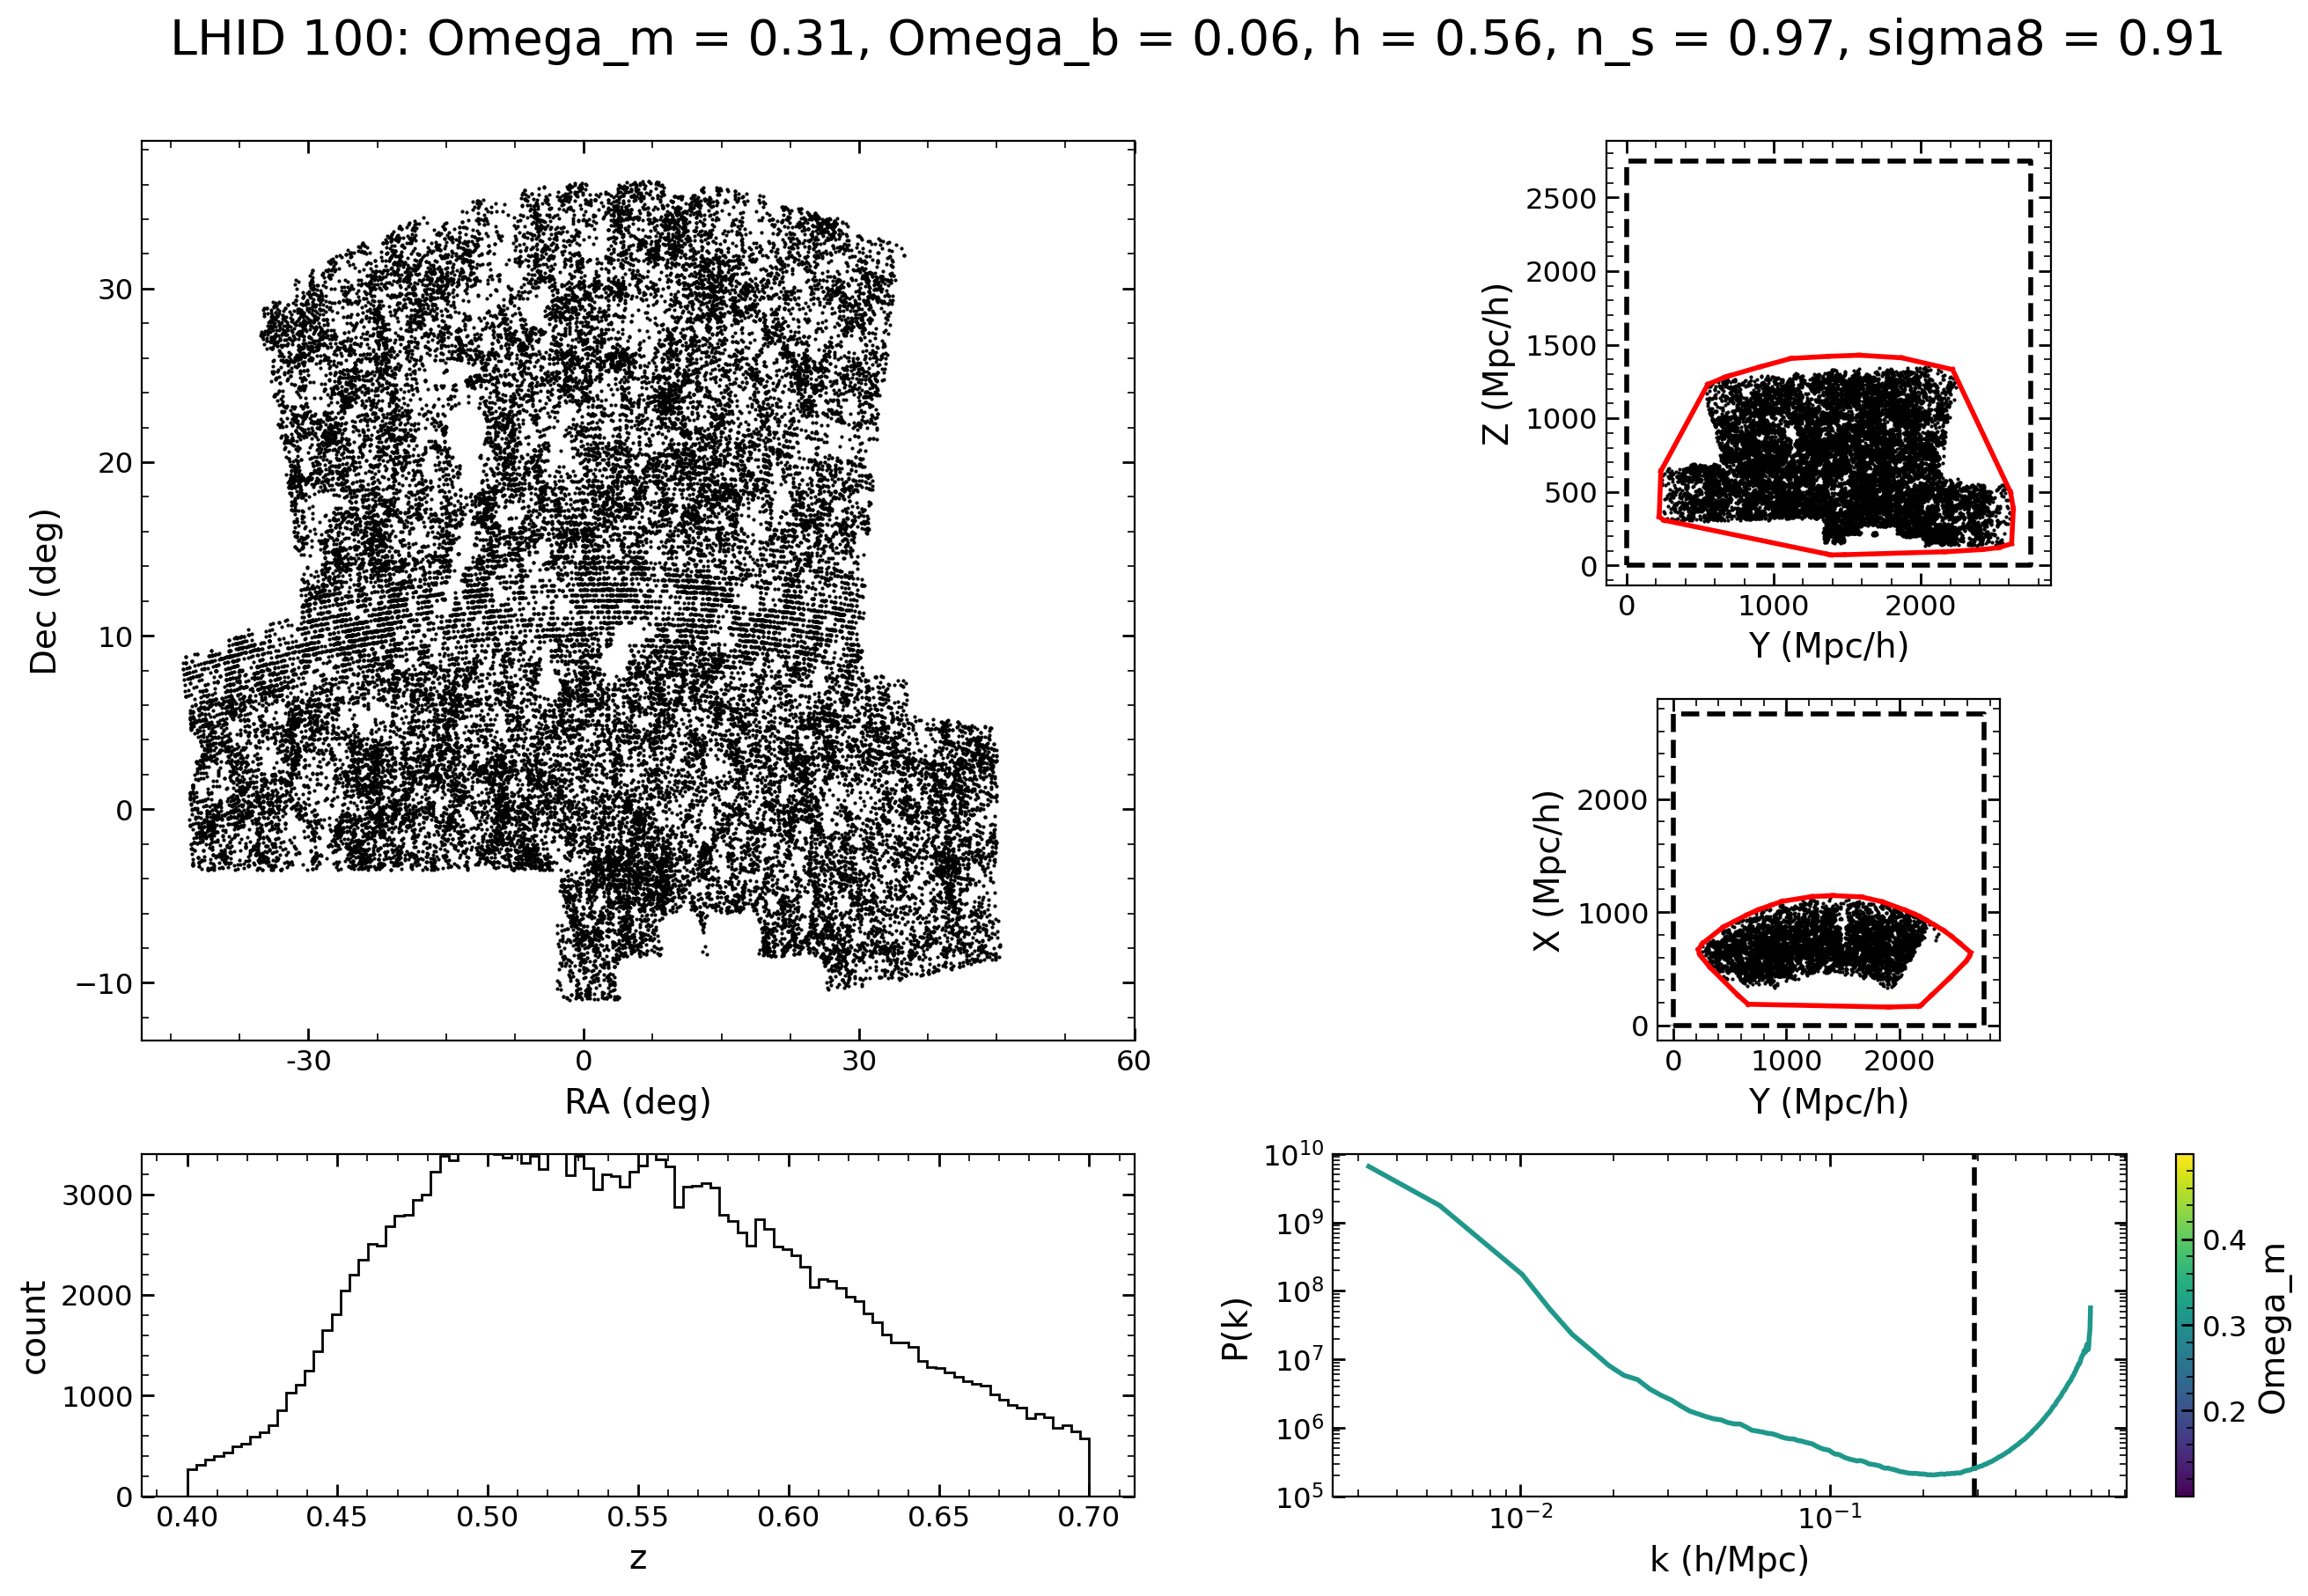

In [6]:
import matplotlib.gridspec as gridspec
from scipy.spatial import ConvexHull


def plot_hull(x, y, ax, **kwargs):
    hull = ConvexHull(np.vstack([x, y]).T)
    for simplex in hull.simplices:
        ax.plot(x[simplex], y[simplex], **kwargs)


def plot_square(origin, L, ax, **kwargs):
    x, y = origin
    ax.plot([x, x+L, x+L, x, x], [y, y, y+L, y+L, y], **kwargs)


def plot_slice(x, y, z, w, ax, **kwargs):
    midz = np.median(z)
    mask = np.abs(z - midz) < w
    ax.plot(x[mask], y[mask], **kwargs)


kwargs = dict(
    marker='.', ms=1, ls='', color='k'
)


def load_and_plot(ind):
    c = cosmos[ind]
    lhid = lhids[ind]
    hod = lhid*10+1
    cap = 'sgc'

    filename = join(suitedir, str(lhid), f'{cap}_lightcone',
                    f'hod{hod:05}_aug{0:05}.h5')
    with h5py.File(filename, 'r') as f:
        z = f['z'][:]
        ra = f['ra'][:]
        dec = f['dec'][:]
        rdz = np.vstack([ra, dec, z]).T
    xyz = sky_to_xyz(rdz, cosmo)
    xyz += np.random.randn(*xyz.shape) * 8/np.sqrt(3)
    diagname = join(suitedir, str(lhid), 'diag', f'{cap}_lightcone',
                    f'hod{hod:05}_aug{0:05}.h5')
    summ = load_lc_Pk(diagname)

    if cap == 'ngc':
        # offset to center (min is about -1870, -1750, -120)
        xyz += [2000, 1800, 250]
        # set length scale of grid (range is about 1750, 3350, 1900)
        L = 3500
    elif cap == 'sgc':
        # offset to center (min is about 800, -1275, -375)
        xyz += [-600, 1400, 400]
        # set length scale of grid (range is about 1750, 3350, 1900)
        L = 2750
    else:
        raise ValueError

    # PLOT!!!
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1.3, 1, 1], hspace=0.3)

    # plot RA-Dec-z
    ax = fig.add_subplot(gs[:2, 0])
    offs = 90
    plot_slice((ra+90) % 360, dec, z, 0.02, ax, **kwargs)
    ax.set_xticks(np.arange(60, 170, 30))
    ax.set_xticklabels((ax.get_xticks() - offs).astype(int))
    ax.set(xlabel='RA (deg)', ylabel='Dec (deg)')

    ax = fig.add_subplot(gs[2, 0])
    ax.hist(z, bins=100, histtype='step', density=False, color=kwargs['color'])
    ax.set_ylim(0, 3400)
    ax.set(xlabel='z', ylabel='count')

    # plot X-Y-Z
    ax = fig.add_subplot(gs[0, 1])
    plot_slice(xyz[:, 1], xyz[:, 2], xyz[:, 0], 20, ax, **kwargs)
    plot_hull(xyz[:, 1], xyz[:, 2], ax, color='r')
    plot_square([0, 0], L, ax, color='k', ls='--')
    ax.set_aspect('equal')
    ax.set(xlabel='Y (Mpc/h)', ylabel='Z (Mpc/h)')

    ax = fig.add_subplot(gs[1, 1])
    plot_slice(xyz[:, 1], xyz[:, 0], xyz[:, 2], 20, ax, **kwargs)
    plot_hull(xyz[:, 1], xyz[:, 0], ax, color='r')
    plot_square([0, 0], L, ax, color='k', ls='--')
    ax.set_aspect('equal')
    ax.set(xlabel='Y (Mpc/h)', ylabel='X (Mpc/h)')

    # plot P(k)
    ax = fig.add_subplot(gs[2, 1])
    s = summ['Pk0']
    nyq = 2*np.pi/L*(N//2)
    ax.axvline(nyq, color='k', ls='--')
    ax.loglog(s['k'], s['value'], label='Pk0', color=cmap(norm(c[0])))
    ax.set(xlabel='k (h/Mpc)', ylabel='P(k)')
    plt.colorbar(mpl.cm.ScalarMappable(
        norm=norm, cmap=cmap), ax=ax, label='Omega_m')
    ax.set_ylim(1e5, 1e10)
    # print(s['k'].min())

    # plot title
    fig.suptitle(f'LHID {lhid}: Omega_m = {c[0]:.2f}, Omega_b = {c[1]:.2f}, h = {c[2]:.2f}, '
                 f'n_s = {c[3]:.2f}, sigma8 = {c[4]:.2f}', y=0.95, fontsize=20)
    return fig


fig = load_and_plot(100)
fig.show()

  0%|          | 0/51 [00:00<?, ?it/s]

  4%|▍         | 2/51 [00:01<00:23,  2.08it/s]

Wrote 0000.png
Failed to load 991


  6%|▌         | 3/51 [00:02<00:37,  1.28it/s]

Failed to load 259


  8%|▊         | 4/51 [00:03<00:46,  1.01it/s]

Failed to load 1044


 10%|▉         | 5/51 [00:04<00:52,  1.13s/it]

Wrote 0001.png


 12%|█▏        | 6/51 [00:05<00:48,  1.08s/it]

Wrote 0002.png


 14%|█▎        | 7/51 [00:07<00:47,  1.09s/it]

Wrote 0003.png


 16%|█▌        | 8/51 [00:08<00:57,  1.35s/it]

Wrote 0004.png


 18%|█▊        | 9/51 [00:10<01:01,  1.47s/it]

Wrote 0005.png


 20%|█▉        | 10/51 [00:12<01:05,  1.60s/it]

Wrote 0006.png


 22%|██▏       | 11/51 [00:15<01:15,  1.88s/it]

Wrote 0007.png


 24%|██▎       | 12/51 [00:17<01:19,  2.04s/it]

Wrote 0008.png


 25%|██▌       | 13/51 [00:18<01:05,  1.74s/it]

Wrote 0009.png


 27%|██▋       | 14/51 [00:19<00:57,  1.55s/it]

Wrote 0010.png


 29%|██▉       | 15/51 [00:21<00:54,  1.52s/it]

Wrote 0011.png


 31%|███▏      | 16/51 [00:24<01:08,  1.94s/it]

Wrote 0012.png


 33%|███▎      | 17/51 [00:26<01:10,  2.07s/it]

Wrote 0013.png
Failed to load 1812


 37%|███▋      | 19/51 [00:29<00:57,  1.81s/it]

Wrote 0014.png


 39%|███▉      | 20/51 [00:31<00:59,  1.92s/it]

Wrote 0015.png


 41%|████      | 21/51 [00:34<01:05,  2.19s/it]

Wrote 0016.png


 43%|████▎     | 22/51 [00:37<01:07,  2.33s/it]

Wrote 0017.png


 45%|████▌     | 23/51 [00:38<00:58,  2.09s/it]

Wrote 0018.png


 47%|████▋     | 24/51 [00:40<00:50,  1.86s/it]

Wrote 0019.png


 49%|████▉     | 25/51 [00:43<01:00,  2.32s/it]

Wrote 0020.png


 51%|█████     | 26/51 [00:46<01:03,  2.52s/it]

Wrote 0021.png


 53%|█████▎    | 27/51 [00:53<01:31,  3.80s/it]

Wrote 0022.png


 55%|█████▍    | 28/51 [00:56<01:19,  3.47s/it]

Wrote 0023.png


 57%|█████▋    | 29/51 [00:58<01:06,  3.03s/it]

Wrote 0024.png


 59%|█████▉    | 30/51 [01:01<01:03,  3.02s/it]

Wrote 0025.png


 61%|██████    | 31/51 [01:04<01:00,  3.02s/it]

Wrote 0026.png


 63%|██████▎   | 32/51 [01:05<00:47,  2.49s/it]

Wrote 0027.png


 65%|██████▍   | 33/51 [01:08<00:47,  2.65s/it]

Wrote 0028.png


 67%|██████▋   | 34/51 [01:11<00:45,  2.67s/it]

Wrote 0029.png


 69%|██████▊   | 35/51 [01:12<00:35,  2.21s/it]

Wrote 0030.png


 71%|███████   | 36/51 [01:13<00:29,  1.97s/it]

Wrote 0031.png


 73%|███████▎  | 37/51 [01:14<00:24,  1.78s/it]

Wrote 0032.png


 75%|███████▍  | 38/51 [01:17<00:27,  2.11s/it]

Wrote 0033.png


 76%|███████▋  | 39/51 [01:20<00:28,  2.38s/it]

Wrote 0034.png


 78%|███████▊  | 40/51 [01:22<00:23,  2.17s/it]

Wrote 0035.png


 80%|████████  | 41/51 [01:26<00:28,  2.81s/it]

Wrote 0036.png


 82%|████████▏ | 42/51 [01:29<00:25,  2.87s/it]

Wrote 0037.png


 84%|████████▍ | 43/51 [01:32<00:23,  2.91s/it]

Wrote 0038.png


 86%|████████▋ | 44/51 [01:34<00:17,  2.52s/it]

Wrote 0039.png


 88%|████████▊ | 45/51 [01:37<00:15,  2.67s/it]

Wrote 0040.png


 90%|█████████ | 46/51 [01:40<00:13,  2.77s/it]

Wrote 0041.png


 92%|█████████▏| 47/51 [01:43<00:11,  2.84s/it]

Wrote 0042.png


 94%|█████████▍| 48/51 [01:46<00:08,  2.84s/it]

Wrote 0043.png


 96%|█████████▌| 49/51 [01:49<00:05,  2.89s/it]

Wrote 0044.png


 98%|█████████▊| 50/51 [01:52<00:02,  2.92s/it]

Wrote 0045.png


100%|██████████| 51/51 [01:53<00:00,  2.23s/it]

Wrote 0046.png


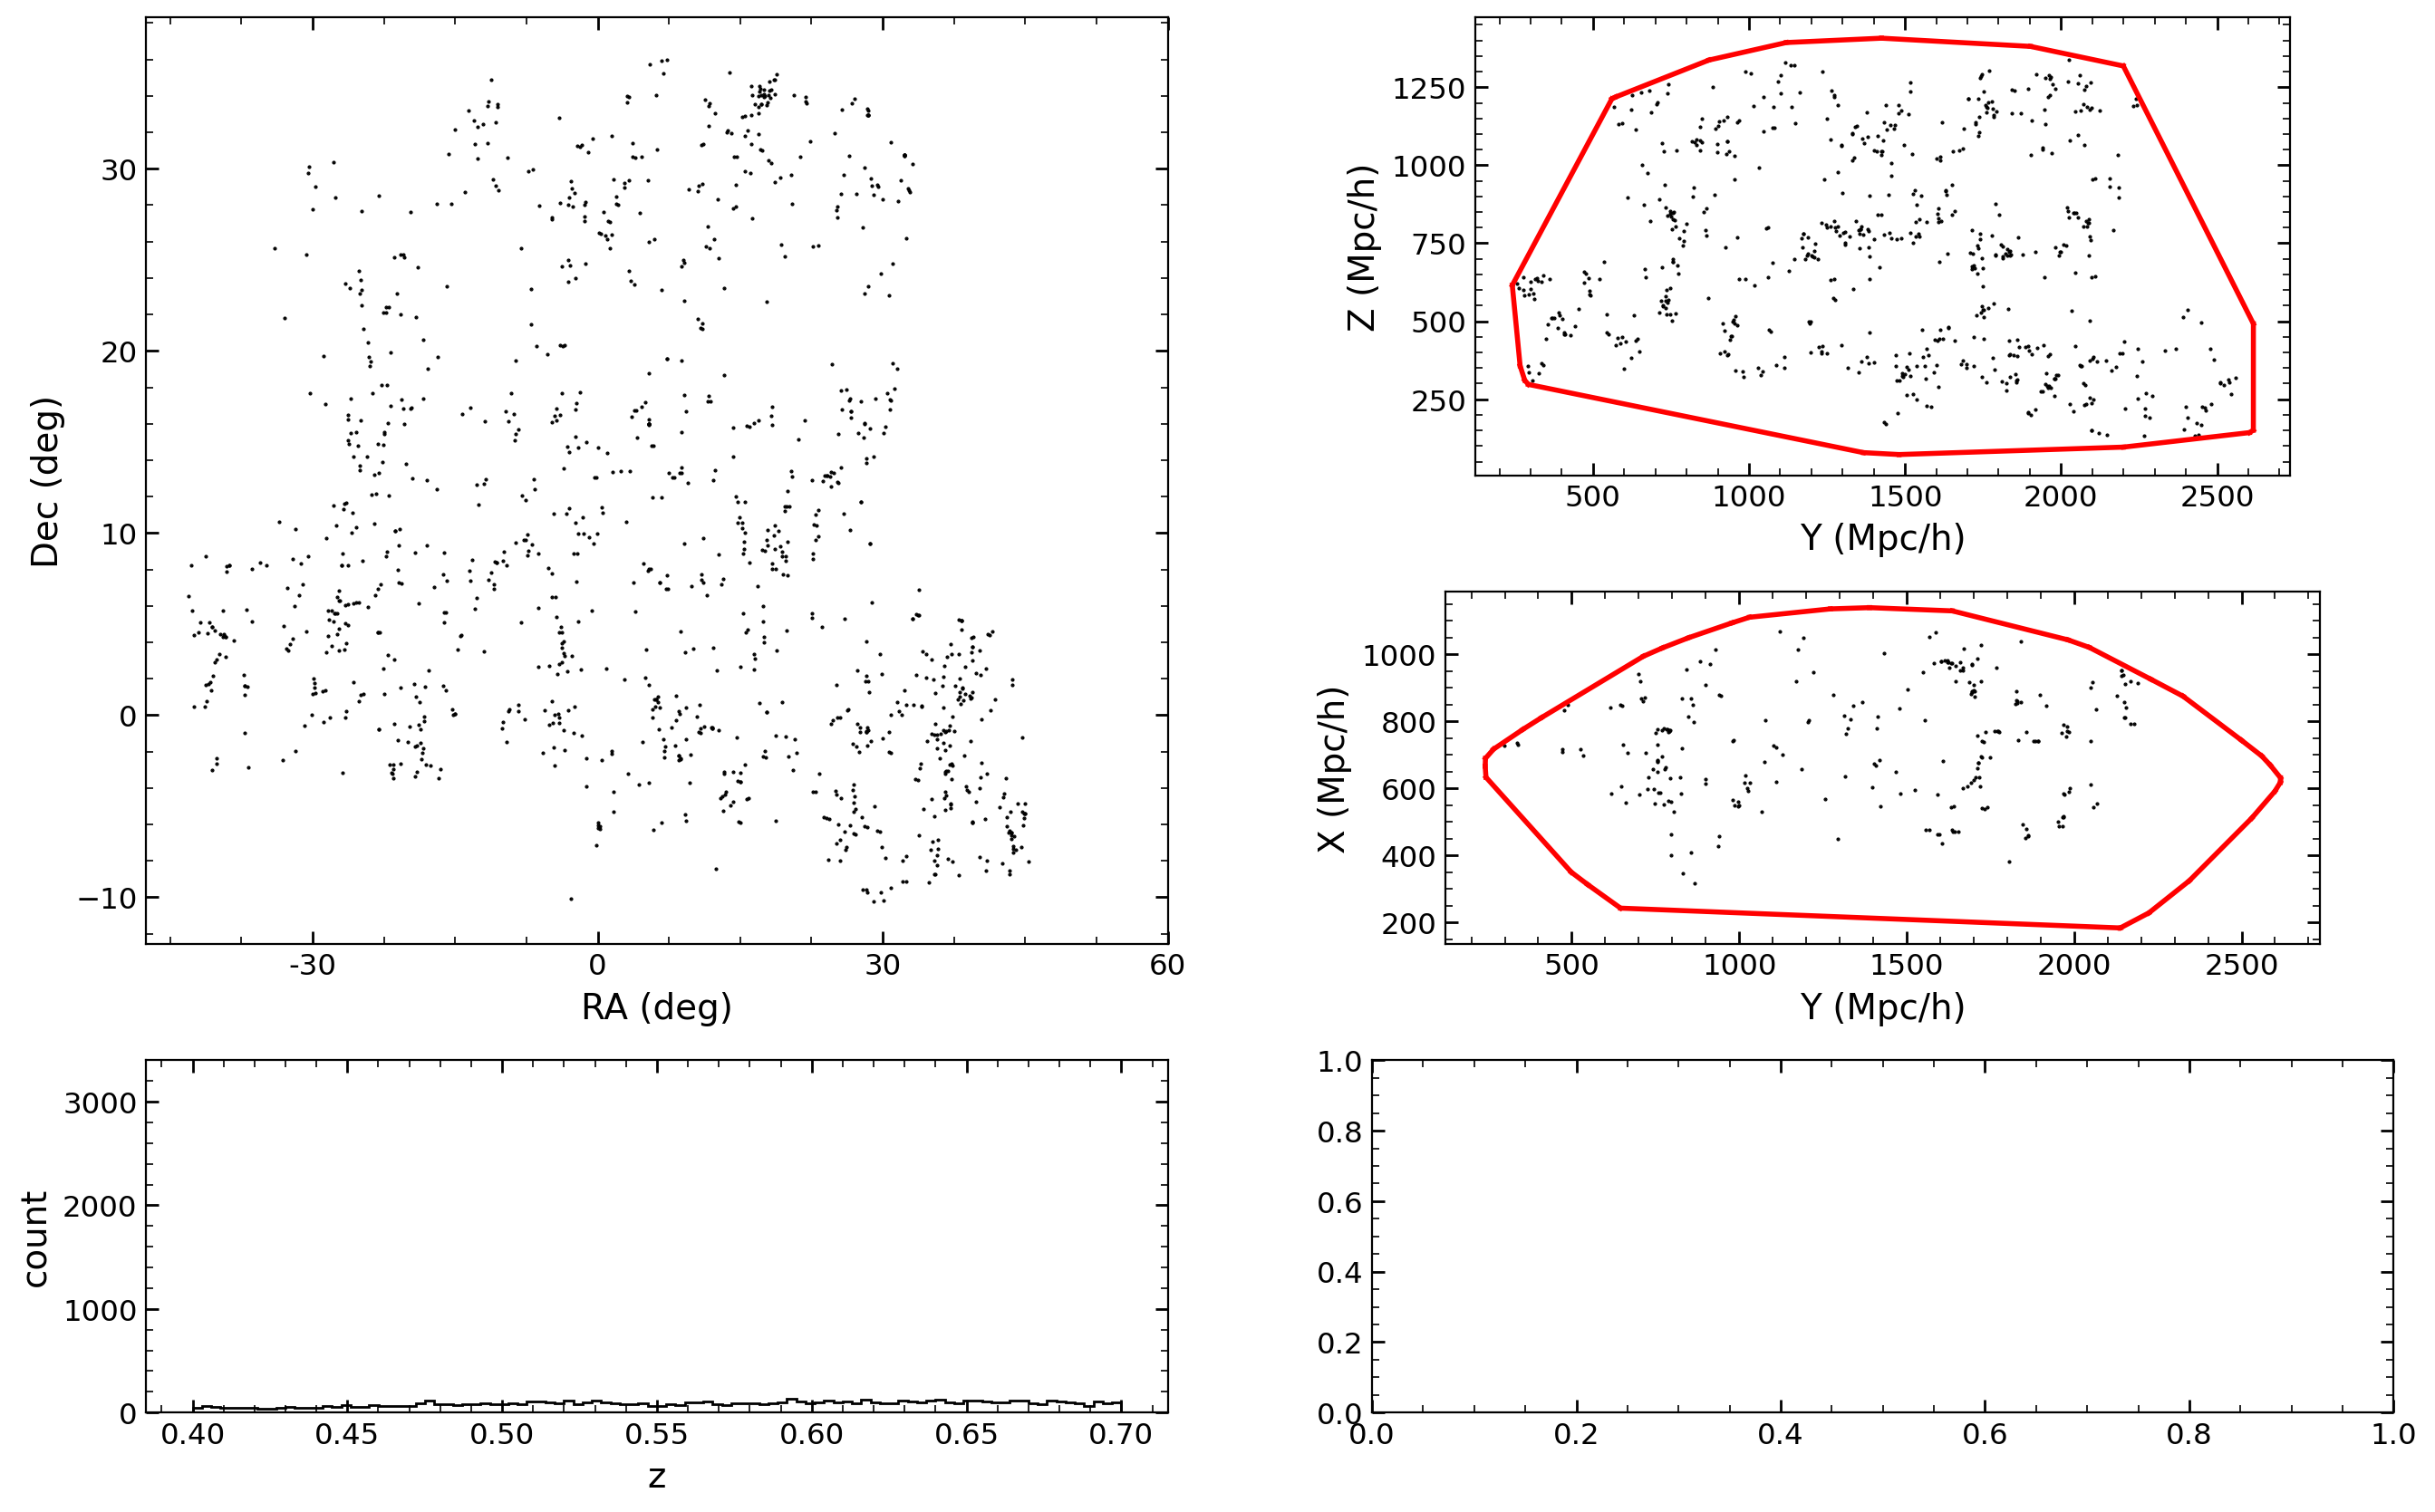

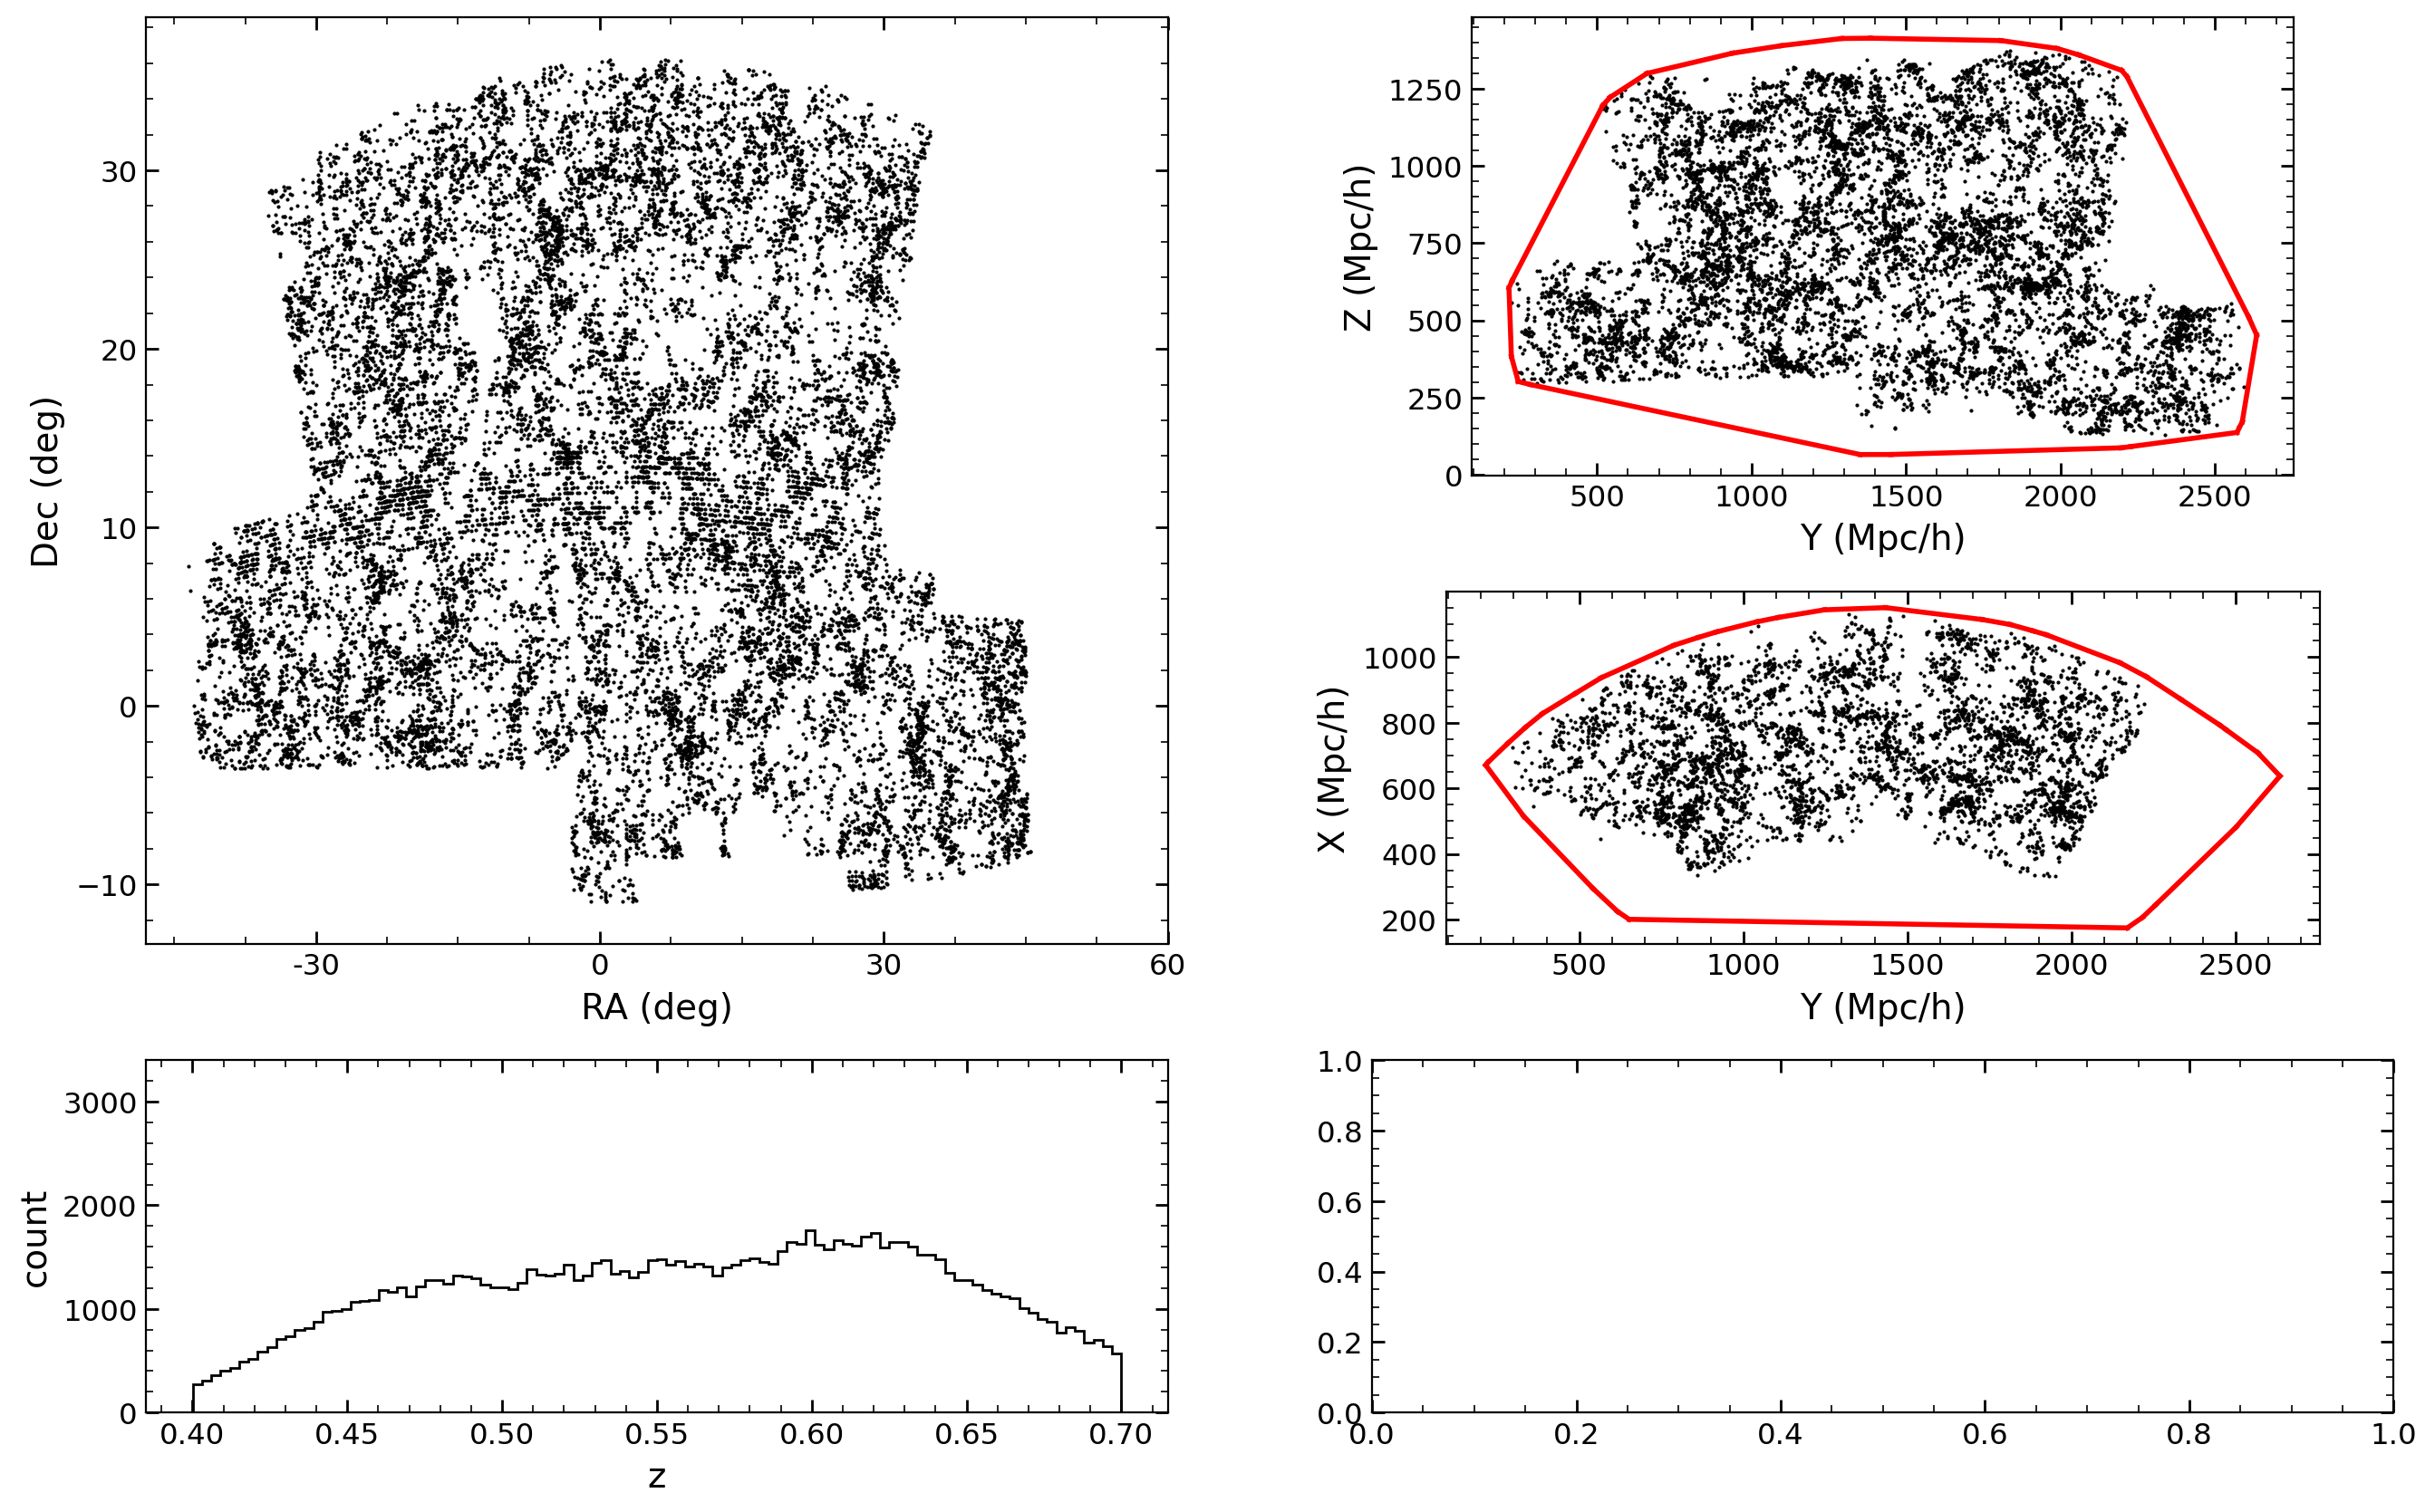

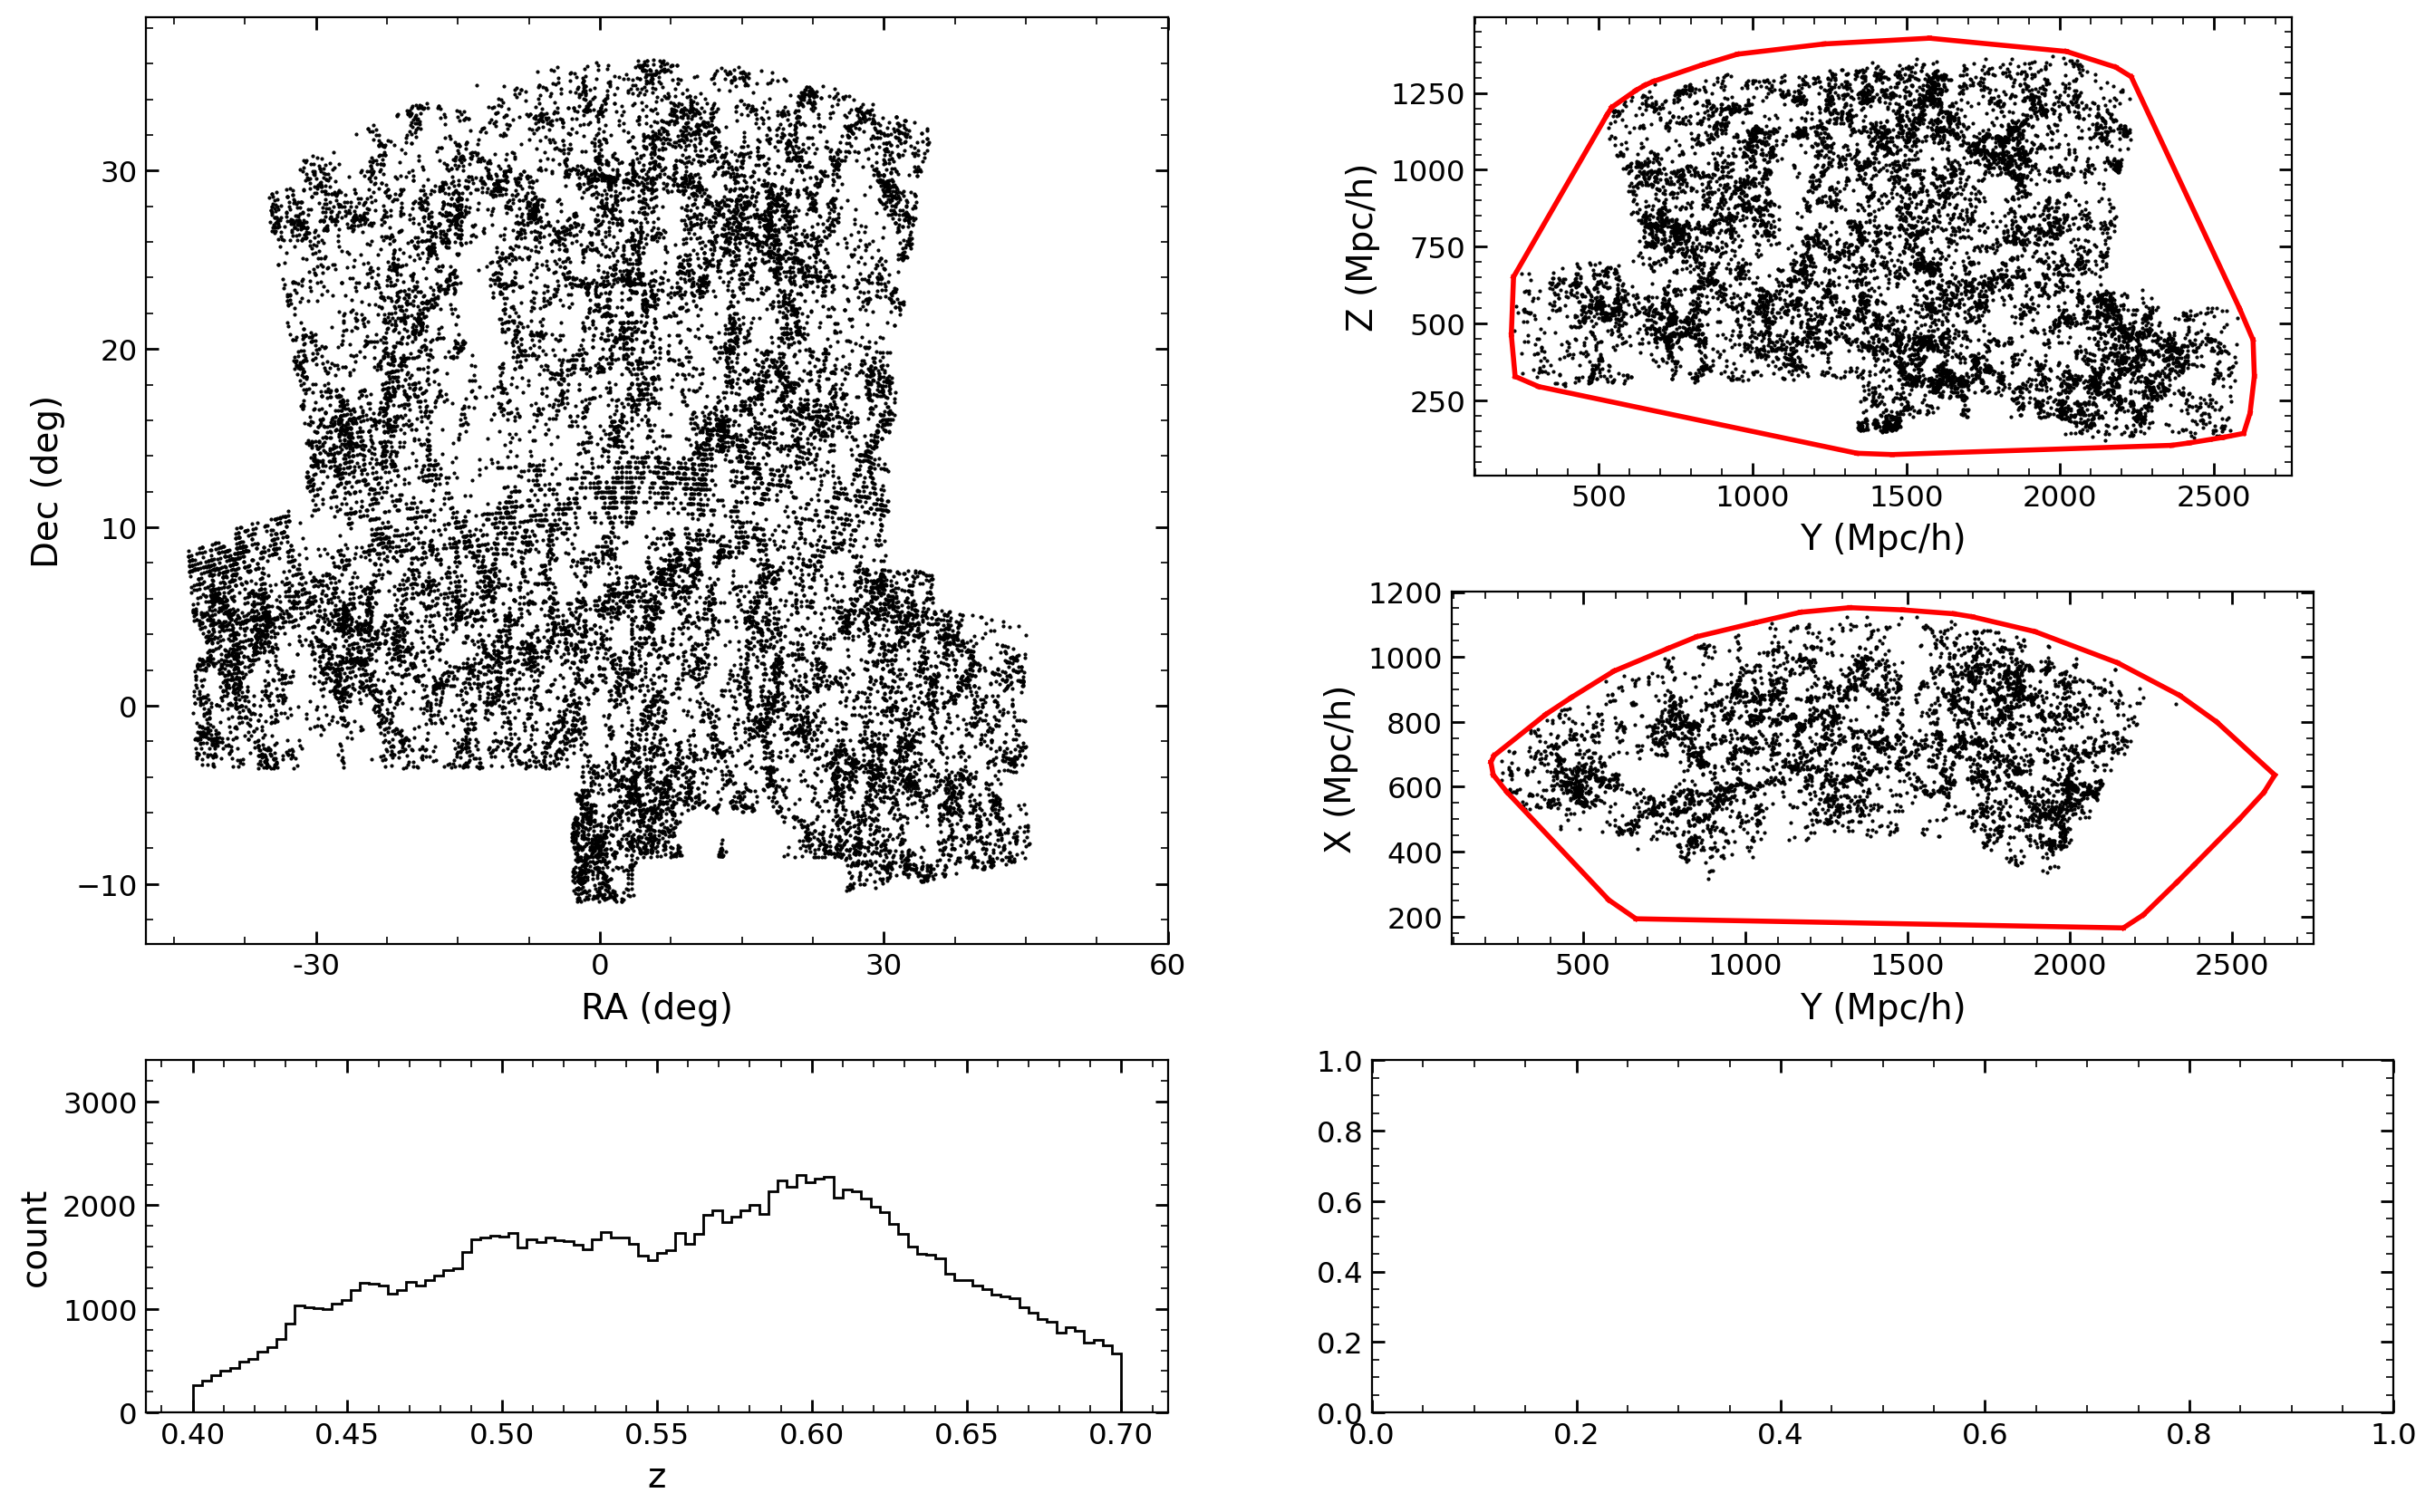

In [148]:
outdir = '../data/images/anim_sgc_lightcone'
os.makedirs(outdir, exist_ok=True)

lhidranked = np.argsort(cosmos[:, 0])
N = 50
lhidranked = lhidranked[10::len(lhidranked)//N]
i = 0
for ind in tqdm(lhidranked):
    try:
        fig = load_and_plot(ind)
    except Exception:
        print(f'Failed to load {ind}')
        continue
    fig.savefig(join(outdir, f'{i:04d}.png'), bbox_inches='tight')
    plt.close(fig)
    print(f'Wrote {i:04d}.png')
    i += 1